In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('merge_df.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,obsTime,WDIR,WDSD,TEMP,HUMD,PRES,SUN,H_24R,...,WSGust,WDGust,Precp,PrecpHour,SunShine,GloblRad,Visb,UVI,Cloud Amount,Year
0,0,0,2018043000,274,0.8,25.3,0.84,1011.9,-99,0.0,...,1.9,290,0,0.0,...,0.0,...,0,...,2018
1,1,1,2018043001,168,0.4,25.1,0.85,1011.3,-99,0.0,...,2.4,90,0,0.0,...,0.0,...,0,...,2018
2,2,2,2018043002,0,0.0,24.9,0.85,1011.3,-99,0.0,...,1.6,60,0,0.0,...,0.0,...,0,...,2018
3,3,3,2018043003,127,0.6,24.3,0.87,1011.1,-99,0.0,...,1.4,30,0,0.0,...,0.0,...,0,...,2018
4,4,4,2018043004,0,0.0,24.3,0.86,1011.1,-99,0.0,...,1.9,70,0,0.0,...,0.0,6,0,3,2018


In [2]:
FEATURES = ["WDIR","WDSD","TEMP","HUMD","PRES","Precp","PrecpHour","SunShine","GloblRad","Cloud Amount","UVI"]

|Feature Name   |   Meaning|   Region|
| ---  | :---: | :---: |
|WDIR   |風向，單位 度，一般風向 0 表示無風|台西|
|WDSD   |風速，單位 公尺/秒|台西|
|TEMP   |溫度，單位 攝氏|台西|
|HUMD   |相對濕度，單位 百分比率|台西|
|PRES   |測站氣壓，單位 百帕|台西|
|Precp   |降水量 (mm)|嘉義|
|PrecpHour   |降水時數 (hr)|嘉義|
|SunShine   |日照時數 (hr)|嘉義|
|GloblRad   |全天空日射量 (MJ/㎡)|嘉義|
|Cloud Amount   |總雲量 (0~10)|嘉義|
|UVI   |紫外線指數|嘉義|

Create a Dataframe with only selected features mentioned above.   
Also, drop all the "..." value in the Dataframe, this will reduce our data size from 7813 to 3285

In [3]:
X_train_raw = df[FEATURES]
X_train_raw["y"] = df["kwh"]
print(X_train_raw.head())
print("Raw Data Shape: ", X_train_raw.shape)

data = X_train_raw.replace({'...':np.nan})
data = data.dropna(axis=0)
print("Data Shape: ", data.shape)

   WDIR  WDSD  TEMP  HUMD    PRES Precp  PrecpHour SunShine  GloblRad  \
0   274   0.8  25.3  0.84  1011.9     0        0.0      ...       0.0   
1   168   0.4  25.1  0.85  1011.3     0        0.0      ...       0.0   
2     0   0.0  24.9  0.85  1011.3     0        0.0      ...       0.0   
3   127   0.6  24.3  0.87  1011.1     0        0.0      ...       0.0   
4     0   0.0  24.3  0.86  1011.1     0        0.0      ...       0.0   

  Cloud Amount  UVI  y  
0          ...    0  0  
1          ...    0  0  
2          ...    0  0  
3          ...    0  0  
4            3    0  0  
Raw Data Shape:  (7813, 12)
Data Shape:  (3285, 12)


c:\users\ndshen\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
data = data.replace({'T':0})
for col in data.columns:
    data[col] = pd.to_numeric(data[col])

Simple analysis on prediction value kwh:

In [5]:
import matplotlib.pyplot as plt
ax = data["y"].plot.kde()
print()
print("Mean of y: ", data["y"].mean())
print("Standard Deviation of y: ", data["y"].std())
print("Max of y: ", data["y"].max())
print("Min of y: ", data["y"].min())


Mean of y:  31.131811263318113
Standard Deviation of y:  17.65853823253906
Max of y:  77
Min of y:  0


c:\users\ndshen\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


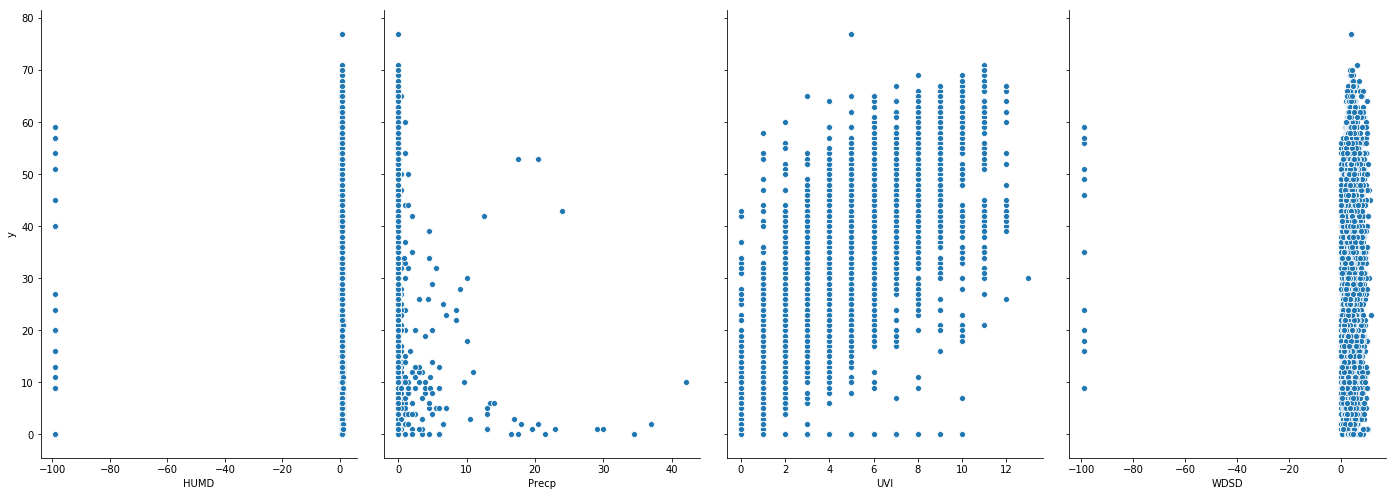

In [6]:
import seaborn as sns
sns.pairplot(data, x_vars=['HUMD','Precp','UVI','WDSD'], y_vars='y', size=7, aspect=0.7)

c:\users\ndshen\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


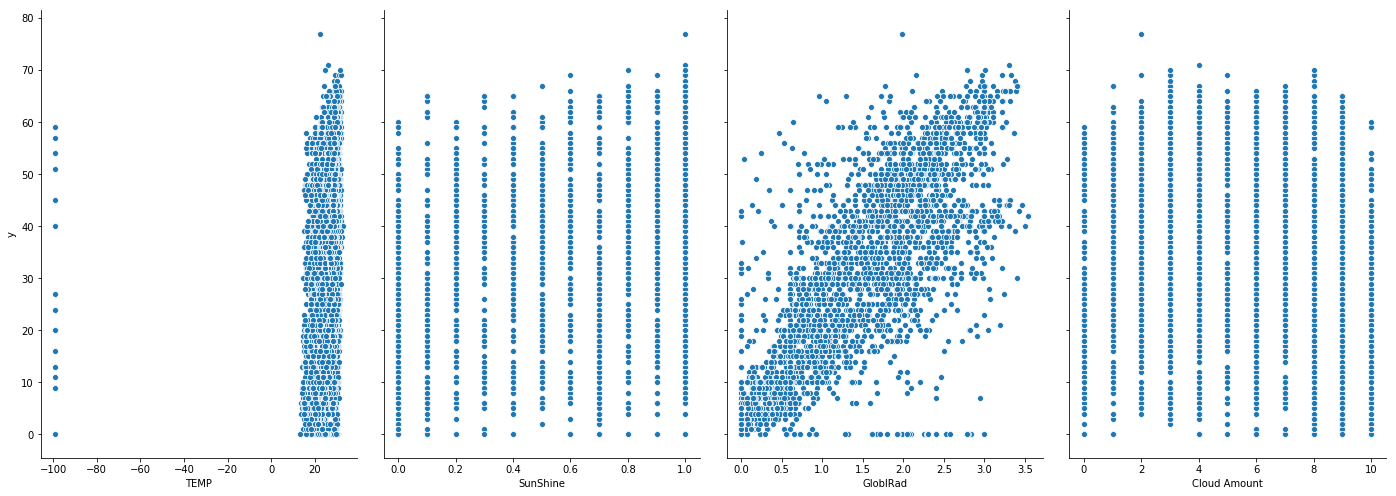

In [7]:
 sns.pairplot(data, x_vars=['TEMP','SunShine','GloblRad','Cloud Amount'], y_vars='y', size=7, aspect=0.7)

Besides Temperature and GloblRad, there is no strong correlation between features and y value(kwh)

Splitting the data randomly into training dataset and testing dataset, with the ratio being 9:1

In [51]:
def Accuracy_Capacity(predictions, observations, capacity):
    predictions = list(predictions)
    observations = list(observations)
    if len(predictions) != len(observations):
        raise ValueError("The sizes of predictions and observations are not equal.")
    abs_error_sum = 0
    for i in range(len(predictions)):
        abs_error_sum += abs(predictions[i] - observations[i])
    
    MAPE = abs_error_sum/(len(predictions)*capacity)
    return(1 - MAPE)

def Accuracy_Actual_Power(predictions, observations):
    predictions = list(predictions)
    observations = list(observations)
    if len(predictions) != len(observations):
        raise ValueError("The sizes of predictions and observations are not equal.")
    
    error_sum = 0
    for i in range(len(predictions)):
        try:
            error_sum += (abs(predictions[i] - observations[i])/observations[i])
        except ZeroDivisionError:
            error_sum += abs(predictions[i] - observations[i])
    MAPE = error_sum/len(predictions)
    return(1 - MAPE)

In [41]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.1)
print("Training Dataset Shape: ", train.shape)
print("Testing Dataset Shape: ", test.shape)

Training Dataset Shape:  (2956, 12)
Testing Dataset Shape:  (329, 12)


In [42]:
from sklearn.preprocessing import StandardScaler
from math import sqrt

scaler = StandardScaler()
train_X = train[FEATURES]
scaler.fit(train_X)
train_x_std = scaler.transform(train_X)
y_mean = train["y"].mean()
train_y_demean = train["y"] - y_mean

test_y_demean = test["y"] - y_mean
scaler_mean = scaler.mean_
scaler_std = [sqrt(x) for x in scaler.var_]
test_x_std = pd.DataFrame()
for i, column in enumerate(test[FEATURES]):
    test_x_std[column] = (test[column] - scaler_mean[i])/scaler_std[i]

print("test_x_std")
print(test_x_std.head())
print()
print("test_y_demean")
print(test_y_demean[:5])

test_x_std
          WDIR      WDSD      TEMP      HUMD      PRES     Precp  PrecpHour  \
3961 -1.048090  0.155654  0.086401  0.057513  0.144523 -0.130226  -0.277158   
5325 -0.955464 -0.001185 -0.886476  0.037766  0.200120 -0.130226  -0.277158   
5047  1.360173 -0.001185  0.035730  0.084314  0.092717 -0.130226  -0.277158   
6030  1.514549  0.155654 -0.470977  0.058924  0.153368 -0.130226  -0.277158   
1337  1.344736  0.038025  0.532303  0.063155  0.049756 -0.130226  -0.277158   

      SunShine  GloblRad  Cloud Amount       UVI  
3961  1.018995  1.027645     -1.228070  0.913771  
5325  1.018995 -0.686985     -1.860504 -1.023432  
5047 -0.677308 -1.515140      0.036799 -1.346300  
6030  1.018995 -0.512023     -1.544287 -0.700565  
1337 -0.192650 -0.663657      0.985451 -1.023432  

test_y_demean
3961    24.771651
5325   -16.228349
5047   -25.228349
6030     4.771651
1337   -11.228349
Name: y, dtype: float64


c:\users\ndshen\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\ndshen\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


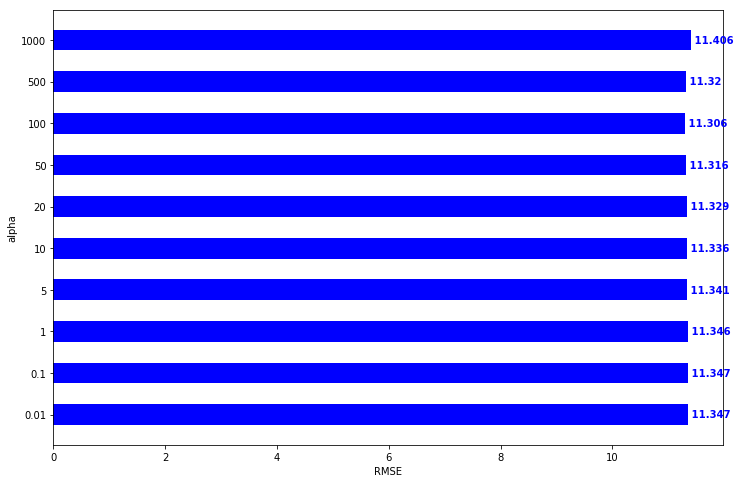

Min RMSE:  11.306098191196755
Min alpha:  100
Accuracy Capacity 0.9229749607006611


In [55]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

alpha_list = [0.01, 0.1, 1, 5, 10, 20, 50, 100, 500, 1000]


#============== not to standarize the features and not to demean the value gives a better result ?!
# train_x_std = train[FEATURES]
# train_y_demean = train["y"]
# test_x_std = test[FEATURES]
# test_y_demean = test["y"]
#==============


rmse_list = []
for a in alpha_list:
    clf = Ridge(alpha=a)
    clf.fit(train_x_std, train_y_demean)
    prediction = clf.predict(test_x_std)
    rmse = sqrt(mean_squared_error(test_y_demean, prediction))
    rmse_list.append(rmse)

x = alpha_list
y = rmse_list

fig, ax = plt.subplots()  
fig.set_size_inches(12,8)
width = 0.5 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind)
ax.set_yticklabels(x, minor=False)
plt.xlabel('RMSE')
plt.ylabel('alpha')    
for i, v in enumerate(y):
    ax.text(v, i, " "+str(round(v,3)), va='center',color='blue', fontweight='bold')

plt.show()
print("Min RMSE: ", min(rmse_list))
print("Min alpha: ", alpha_list[rmse_list.index(min(rmse_list))])

best_alpha = alpha_list[rmse_list.index(min(rmse_list))]
clf = Ridge(alpha=best_alpha)
clf.fit(train_x_std, train_y_demean)
prediction = clf.predict(test_x_std)
print("Accuracy Capacity",Accuracy_Capacity(prediction+y_mean, test_y_demean+y_mean, 112.7))

In [53]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_x_std, train_y_demean)
prediction = reg.predict(test_x_std)
rmse = sqrt(mean_squared_error(test_y_demean, prediction))
score = reg.score(test_x_std, test_y_demean)
print("RMSE: ", rmse)
print("R-squared", score)
print("Accuracy Capacity",Accuracy_Capacity(prediction+y_mean, test_y_demean+y_mean, 112.7))

RMSE:  11.346871527901458
R-squared 0.5672328976025378
Accuracy Capacity 0.9231664784129826


In [57]:
import statsmodels.formula.api as sm
result = sm.OLS(train_y_demean, train_x_std).fit()
print(result.summary())

prediction = result.predict(test_x_std)
rmse = sqrt(mean_squared_error(test_y_demean, prediction))
print()
print("RMSE: ",rmse)
print("Accuracy Capacity",Accuracy_Capacity(prediction+y_mean, test_y_demean+y_mean, 112.7))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     385.6
Date:                Mon, 20 May 2019   Prob (F-statistic):               0.00
Time:                        16:09:25   Log-Likelihood:                -11370.
No. Observations:                2956   AIC:                         2.276e+04
Df Residuals:                    2945   BIC:                         2.283e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2437      0.262      0.931      0.3

In [59]:
result = sm.OLS(train["y"], train[["GloblRad"]]).fit()
prediction = result.predict(test[["GloblRad"]])
rmse = sqrt(mean_squared_error(test["y"], prediction))
print(result.summary())
print()
print("RMSE: ",rmse)
print("Accuracy Capacity: ", Accuracy_Capacity(test["y"], prediction, 112.7))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                 2.325e+04
Date:                Mon, 20 May 2019   Prob (F-statistic):               0.00
Time:                        16:10:37   Log-Likelihood:                -11553.
No. Observations:                2956   AIC:                         2.311e+04
Df Residuals:                    2955   BIC:                         2.311e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GloblRad      19.5795      0.128    152.484      0.0

In [69]:
from sklearn import tree
decision_tree = tree.DecisionTreeRegressor()
decision_tree = decision_tree.fit(train_x_std, train_y_demean)
predictions = decision_tree.predict(test_x_std)
rmse = sqrt(mean_squared_error(test_y_demean, predictions))
print("RMSE: ",rmse)
print("Accuracy Capacity",Accuracy_Capacity(prediction+y_mean, test_y_demean+y_mean, 112.7))

RMSE:  12.536875698499816
Accuracy Capacity 0.7464659995136211
